<a href="https://colab.research.google.com/github/Shubhankitsirvaiya/Appliance-Energy-Prediction/blob/main/Capstone_Project_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data-driven prediction of energy use of appliances
The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions
were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the
temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for
10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded
from a public data set from Reliable Prognosis (rp5.ru) and merged together with the
experimental data sets using the date and time column. Two random variables have been
included in the data set for testing the regression models and to filter out non-predictive attributes
(parameters).

date time year-month-day hour:minute:second
Appliances, energy use in Wh (Dependent variable)
lights, energy use of light fixtures in the house in Wh (Drop this column)
T1, Temperature in kitchen area, in Celsius
RH1, Humidity in kitchen area, in % 
T2, Temperature in living room area, in Celsius RH2,
Humidity in living room area, in %
T3, Temperature in laundry room area
RH3, Humidity in laundry room area, in % T4, Temperature in office room, in Celsius RH4,
Humidity in office room, in %
T5, Temperature in bathroom, in Celsius
RH5, Humidity in bathroom, in % T6, Temperature outside the building (north side), in Celsius
RH6, Humidity outside the building (north side), in %
T7, Temperature in ironing room , in Celsius
RH7, Humidity in ironing room, in % T8, Temperature in teenager room 2, in Celsius RH8,
Humidity in teenager room 2, in %
T9, Temperature in parents room, in Celsius
RH9, Humidity in parents room, in % To, Temperature outside (from Chievres weather station), in
Celsius Pressure (from Chievres weather station), in mm Hg RHout, Humidity outside (from
Chievres weather station), in %
Wind speed (from Chievres weather station), in m/s
Visibility (from Chievres weather station), in km
Tdewpoint (from Chievres weather station), Â°C
rv1, Random variable 1, nondimensional
rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station
(Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis,
rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of
weather data.

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [56]:
df=pd.read_csv('/content/drive/MyDrive/Copy of data_application_energy.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [57]:
df.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [59]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


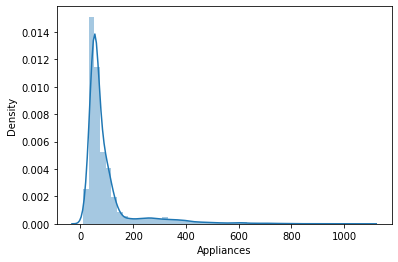

In [60]:
sns.distplot(df['Appliances'])

In [61]:
#

In [62]:
#sns.lineplot(df[:1000]['T1'],df[:1000]['Appliances'])

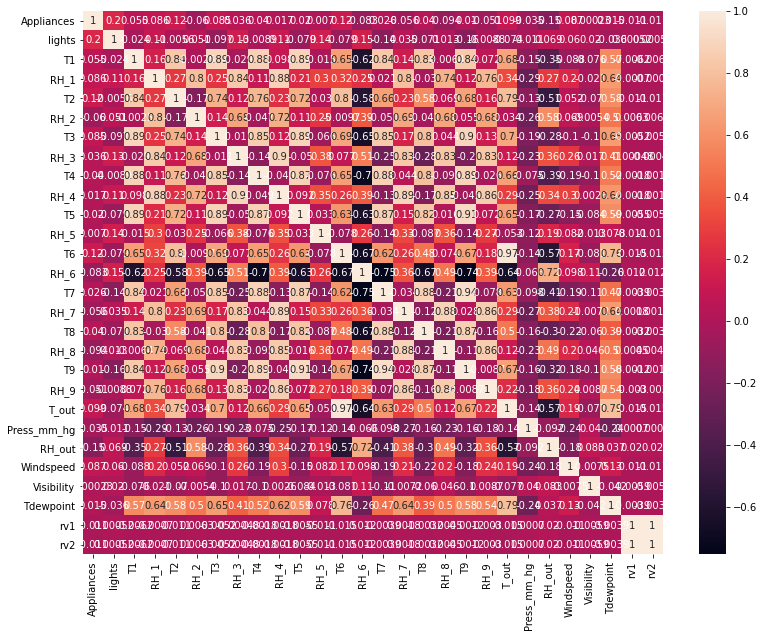

In [63]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True,)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


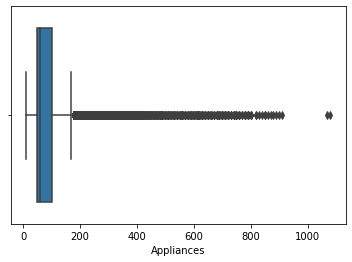

In [64]:
sns.boxplot(df['Appliances'])

- - time series type data. 
- 

In [65]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [66]:
import datetime 

In [67]:
def hour_fet(x):
   return pd.to_datetime(x).hour

def weekday_fet(x):
   return pd.to_datetime(x).weekday()




In [68]:
df['hour']=df['date'].apply(hour_fet)
df['weekday']=df['date'].apply(weekday_fet)

In [69]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,weekday
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,17,0
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,17,0
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,17,0
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,17,0
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,17,0


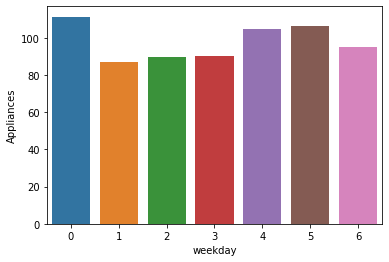

In [70]:
weekday_eng=pd.DataFrame(df.groupby('weekday')['Appliances'].mean()).reset_index()
sns.barplot(x=weekday_eng['weekday'],y=weekday_eng['Appliances'])

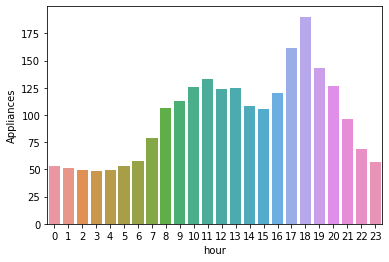

In [71]:
hour_eng=pd.DataFrame(df.groupby('hour')['Appliances'].mean()).reset_index()
sns.barplot(x=hour_eng['hour'],y=hour_eng['Appliances'])

In [72]:
temp_col=['T1','T2','T3','T4','T5','T6','T7','T8','T9']
hum_col=['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9']

In [73]:
df['avg_temp']=0
for i in temp_col:
  df['avg_temp']=df['avg_temp']+df[i]
df['avg_temp']=df['avg_temp']/len(temp_col)

In [74]:
df['avg_hum']=0
for i in hum_col:
  df['avg_hum']=df['avg_hum']+df[i]
df['avg_hum']=df['avg_hum']/len(hum_col)

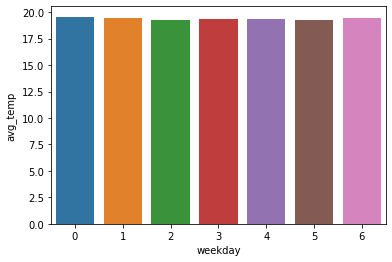

In [75]:
weekday_temp=pd.DataFrame(df.groupby('weekday')['avg_temp'].mean()).reset_index()
sns.barplot(x=weekday_temp['weekday'],y=weekday_temp['avg_temp'])

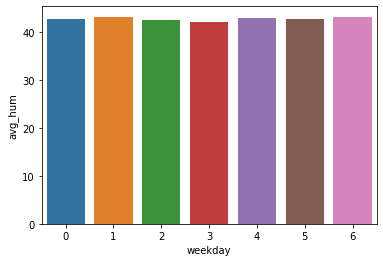

In [76]:
weekday_hum=pd.DataFrame(df.groupby('weekday')['avg_hum'].mean()).reset_index()
sns.barplot(x=weekday_hum['weekday'],y=weekday_hum['avg_hum'])

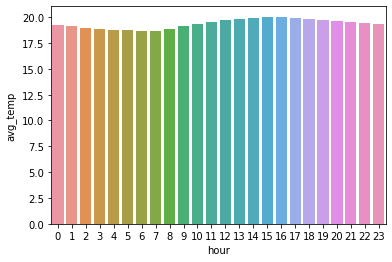

In [77]:
hour_temp=pd.DataFrame(df.groupby('hour')['avg_temp'].mean()).reset_index()
sns.barplot(x=hour_temp['hour'],y=hour_temp['avg_temp'])

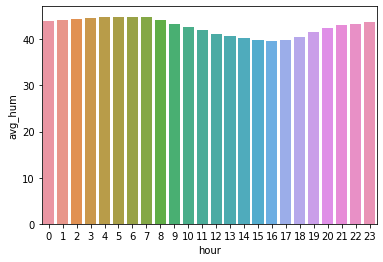

In [78]:
hour_hum=pd.DataFrame(df.groupby('hour')['avg_hum'].mean()).reset_index()
sns.barplot(x=hour_hum['hour'],y=hour_hum['avg_hum'])

In [79]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'hour', 'weekday', 'avg_temp',
       'avg_hum'],
      dtype='object')

In [80]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,weekday,avg_temp,avg_hum
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,17,0,17.167407,50.910741
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,17,0,17.149630,50.827222
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,17,0,17.103704,50.628889
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,17,0,17.067037,50.574815
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,17,0,17.070741,50.732963


In [89]:
#lets create features based on consumption level.
# is for a particular 10 mins the enerygy consumption is far greater than hour avg then it will be high consumtion or else
def consump_level(x):
  if x>25:
    return 'high consump'
  elif x<(-25):
    return 'low consump'

df_1=df.join(hour_eng,on='hour',rsuffix='_all')
df_1['hourly_diff']=df_1['Appliances']-df_1['Appliances_all']
df_1['level']=df_1['hourly_diff'].apply(consump_level)

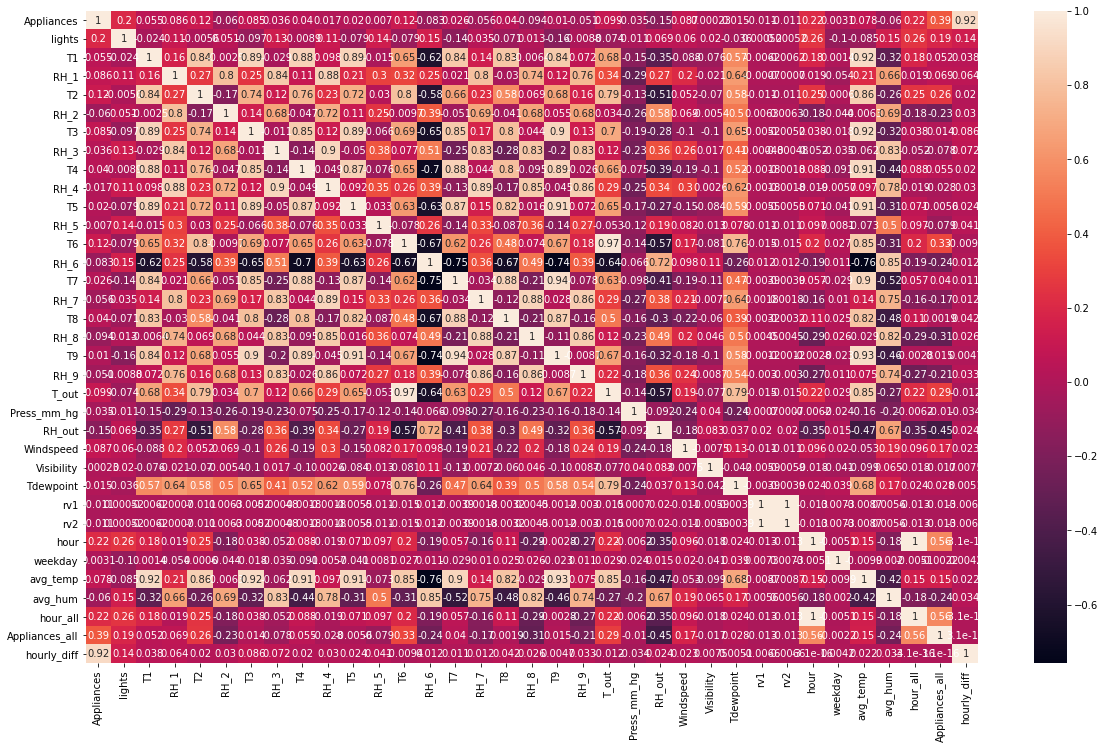

In [102]:
plt.figure(figsize=(20,12))
sns.heatmap(df_1.corr(),annot=True,)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,weekday,avg_temp,avg_hum,hour_all,Appliances_all
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,17,0,17.167407,50.910741,17,161.352657
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,17,0,17.149630,50.827222,17,161.352657
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,17,0,17.103704,50.628889,17,161.352657
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,17,0,17.067037,50.574815,17,161.352657
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,17,0,17.070741,50.732963,17,161.352657


In [26]:
other_col=['date', 'Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'hour', 'weekday']

In [27]:
df_other=df[other_col]

In [28]:
df_other

,date,Appliances,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,weekday
0,2016-01-11 17:00:00,60,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,17,0
1,2016-01-11 17:10:00,60,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,17,0
2,2016-01-11 17:20:00,50,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,17,0
3,2016-01-11 17:30:00,50,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,17,0
4,2016-01-11 17:40:00,60,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,17,4
19731,2016-05-27 17:30:00,90,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,17,4
19732,2016-05-27 17:40:00,270,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,17,4
19733,2016-05-27 17:50:00,420,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,17,4


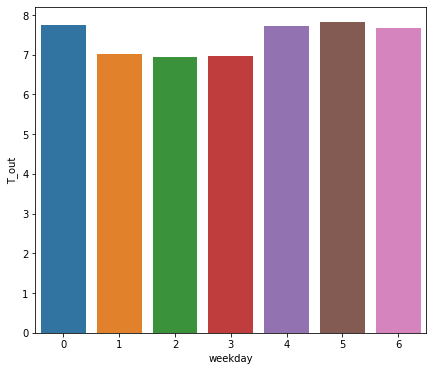

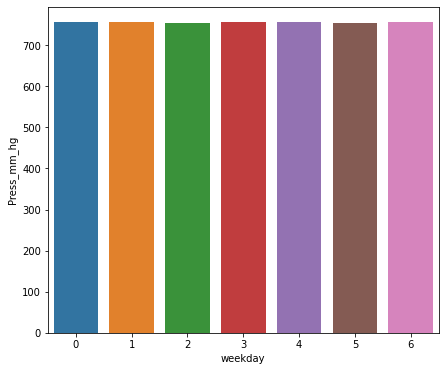

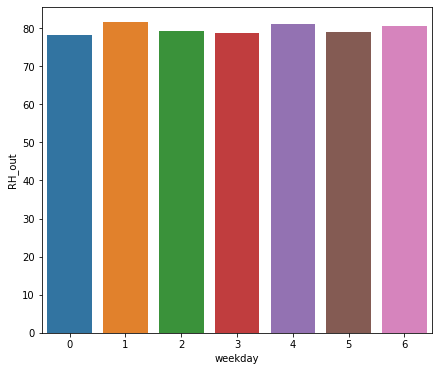

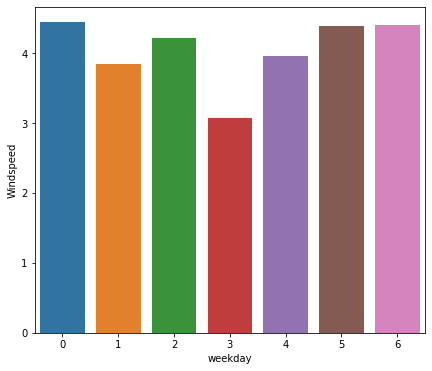

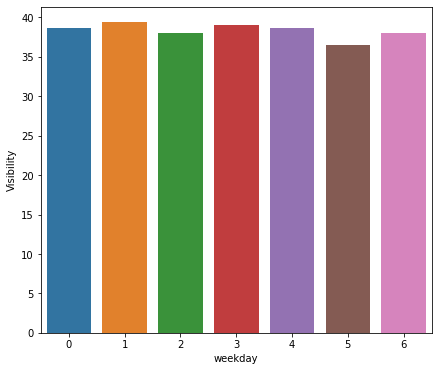

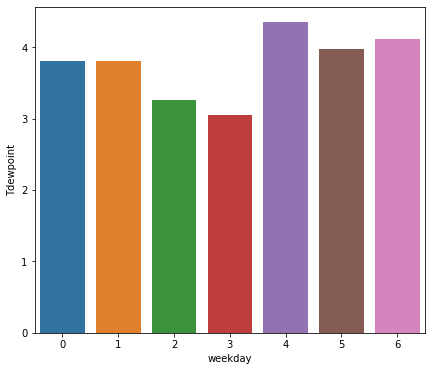

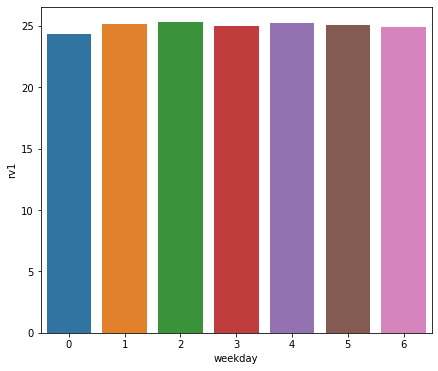

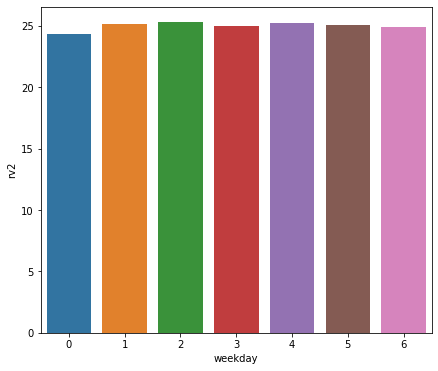

In [29]:
for i in df_other.columns[2:10]:
  plt.figure(figsize=(7,6))
  df_week=pd.DataFrame(df_other.groupby('weekday')[i].mean()).reset_index()
  sns.barplot(x=df_week['weekday'],y=df_week[i])



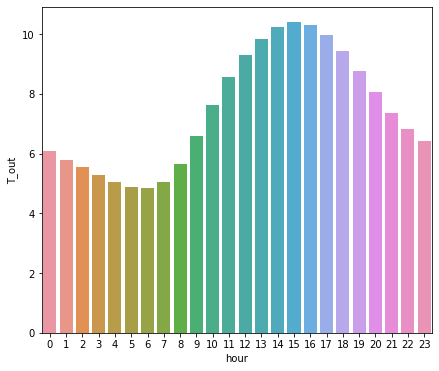

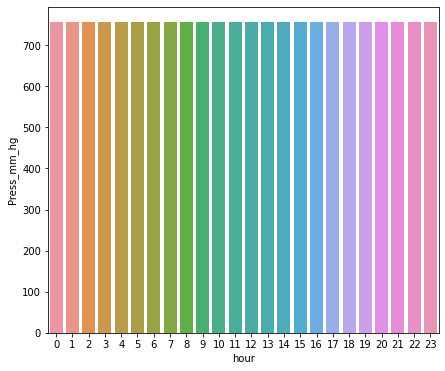

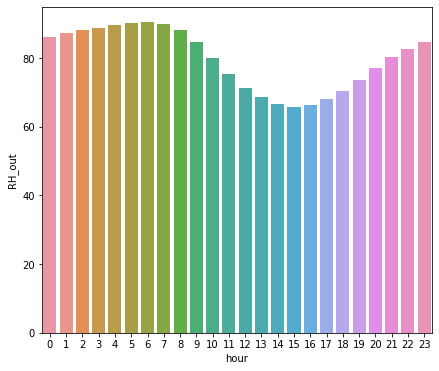

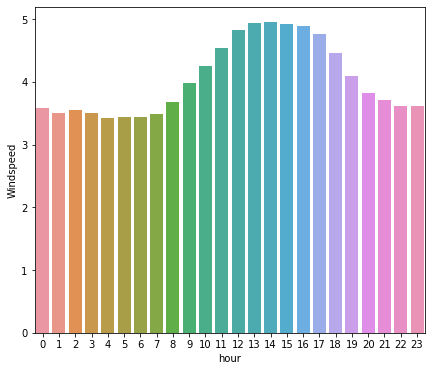

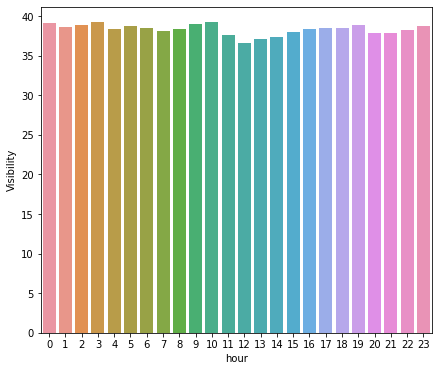

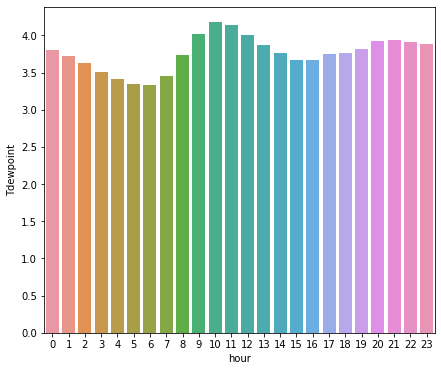

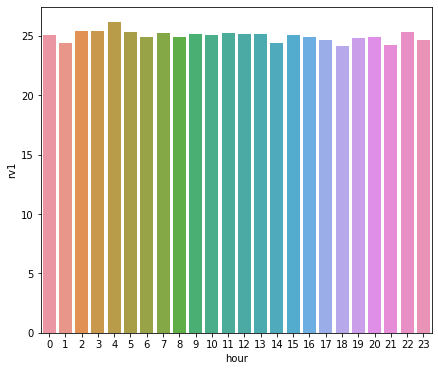

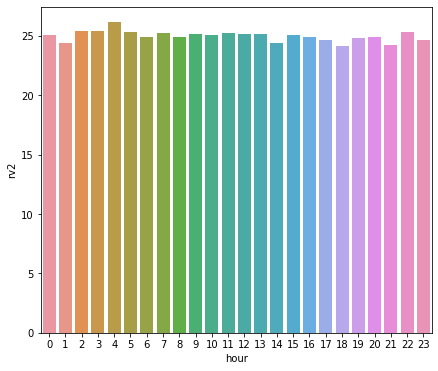

In [30]:
for i in df_other.columns[2:10]:
  plt.figure(figsize=(7,6))
  df_hour=pd.DataFrame(df_other.groupby('hour')[i].mean()).reset_index()
  sns.barplot(x=df_hour['hour'],y=df_hour[i])

In [31]:
'''
X=df_other.drop(['date','Appliances'],axis=1)
y=df_other['Appliances']
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
rf=RandomForestRegressor(n_estimators=10)
rf.fit(X_train,y_train)'''


"\nX=df_other.drop(['date','Appliances'],axis=1)\ny=df_other['Appliances']\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import r2_score,mean_squared_error\nfrom sklearn.model_selection import GridSearchCV\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)\nscaler=MinMaxScaler()\nX_train=scaler.fit_transform(X_train)\nX_test=scaler.transform(X_test)\nrf=RandomForestRegressor(n_estimators=10)\nrf.fit(X_train,y_train)"